## LED Scenario
This scenario will assess whether the introduction of LED changes the results already obtained in the Baseline scenario or not.  

In [5]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [6]:
mp = ixmp.Platform()

Firsst of all we need to import the base scenario, clone it and call it scen.

In [7]:
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen = base.clone(model, 'led_introduction','introducing LED technology in Westeros',
                  keep_solution=False)
scen.check_out()

We define the previous year and the year of the actual analysis.

In [8]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'

In [9]:
base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

### Finally introducing LED
Now it's time to introduce the LED in to the mix of overcrowded lighting techonology.
It is also needed to define what LEDs are, what they utilise as energy and what they give in return. 

In [10]:
scen.add_set("technology", ['LED'])

In [11]:
LED_out = make_df(base_output, technology='LED', commodity='light', 
                   level='useful', value=1.0)
scen.add_par('output', LED_out)

LED_in = make_df(base_input, technology='LED', commodity='electricity',  
                  level='final', value=1.0)
scen.add_par('input', LED_in)

## Operational constraints and parameters
Here it is needed to define the capacity factor, lifetime and historical spread of technology. 
This will be needed later as without an initial presence of LED in Westereos, the penetration of technology will always be 0. So it is set now to be that only 10% of the light system is made up by LEDs.
* * *

$\sum_{y^V \leq y,m} \text{ACT}_{n,t,y^V,y,m,h} \leq$  
$\text{initial_activity_up}_{n,t,y,h}
        \cdot \frac{ \Big( 1 + growth\_activity\_up_{n,t,y,h} \Big)^{|y|} - 1 }
                   { growth\_activity\_up_{n,t,y,h} }+ \Big( 1 + growth\_activity\_up_{n,t,y,h} \Big)^{|y|} \cdot \Big( \sum_{y^V \leq y-1,m} ACT_{n,t,y^V,y-1,m,h} + \sum_{m} historical\_activity_{n,t,y-1,m,h}\Big)$  
                   
As shown in the equation, if the initial population of LED is 0, it is impossible to grow, whatever it is the diffusion rate set.

In [12]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

In [13]:
capacity_factor = {
    'coal_ppl': 1,
    'wind_ppl': 0.36,
    'bulb': 1, 
    'LED' : 1,
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scen.add_par('capacity_factor', df)

In [14]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

In [15]:
lifetime = {
    'coal_ppl': 20,
    'wind_ppl': 20,
    'bulb': 1,
    'LED' : 4, #LED lifetime in hours goes from 35000 to 50000. 35000/8760 = 3.99 years. Engineers say it's 4 years.
}

for tec, val in lifetime.items():    
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scen.add_par('technical_lifetime', df)

In [16]:
history = [690]
demand_per_year = 40 * 12 * 1000 / 8760

grid_efficiency = 0.9
historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / grid_efficiency
LED_fraction = 0.1 # 10% are LEDs
coal_fraction = 0.6

base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}


old_activity = {
    'coal_ppl': coal_fraction * historic_generation,
    'wind_ppl': (1 - coal_fraction) * historic_generation,
    'LED' : LED_fraction * historic_demand,
    'bulb' : (1-LED_fraction) * historic_demand
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scen.add_par('historical_activity', df)
    
    
act_to_cap = {
    'coal_ppl': 1 / 10 / capacity_factor['coal_ppl'] / 2, # 20 year lifetime
    'wind_ppl': 1 / 10 / capacity_factor['wind_ppl'] / 2,
    'LED': 1 / 10 / capacity_factor['LED'] / 0.4, # 4 years lifetime
    'bulb': 1 / 10 / capacity_factor['bulb'] / 0.1, #1 year lifetime
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scen.add_par('historical_new_capacity', df)


## Objective Function
Now it is needed to insert the investment cost of the technology. Well, the LEDs are way more expensive per watt utilised as they are more efficient in converting electricity in light. 
After a quick search on Amazon.it  (source: https://www.amazon.it/AmazonBasics-Lampadina-E27-equivalenti-100W/dp/B0716CJ7YX/ref=sr_1_6?dchild=1&keywords=lampadina+led+e27&qid=1590848358&sr=8-6) we can set the cost of LED.
(The link is in Italian, but it is only needed to check price, quantity and wattage).

In [17]:
scen.add_par("interestrate", model_horizon, value=0.05, unit='-')

In [18]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}

# Adding a new unit to the library
mp.add_unit('USD/kW')     

INFO:root:unit `USD/kW` is already defined in the platform instance


In [19]:
# in $ / kW (specific investment cost)
costs = {
    'coal_ppl': 500,
    'wind_ppl': 1500,
    'bulb': 5,
    'LED' : 266, #15W LED lamp costs 4€. 4€/0.015kW = 266 1€ almost = 1$. 
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scen.add_par('inv_cost', df)

## Solving the model


In [20]:
from message_ix import log

log.info('version number prior to commit: {}'.format(scen.version))

scen.commit(comment='basic model of Westeros electrification')

log.info('version number prior committing to the database: {}'.format(scen.version))

INFO:message_ix:version number prior to commit: 90
INFO:message_ix:version number prior committing to the database: 90


In [21]:
scen.solve()

In [22]:
scen.var('OBJ')['lvl']

238193.296875

In [23]:
from tools import Plots
p = Plots(scen, country, firstyear=model_horizon[0])

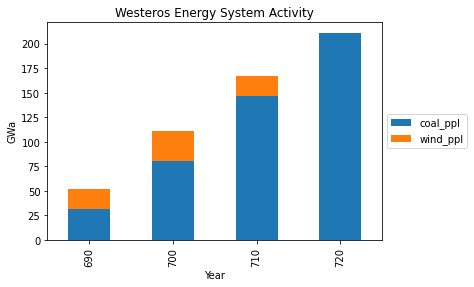

In [24]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

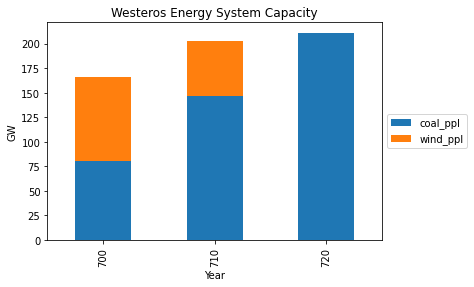

In [25]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

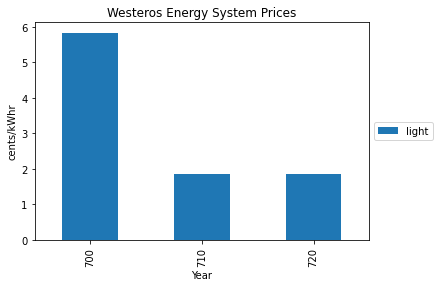

In [26]:
p.plot_prices(subset=['light'], baseyear=True)

## Introducing emissions for Coal Power Plant

Now we want to understand which level of CO2 taxation would make lighting expensive enough to push people into buying LEDs.
Let's first create a new scenario as a clone of the previous one and call it *scen*

In [27]:
emissions = scen.clone(model, 'emission_tax','introducing LED technology in Westeros',
                  keep_solution=False)
emissions.check_out()

Now we need to reduce that Bulb efficiency. In the baseline scenario it set at 1 (as it is defined as ouput/input). As nowhere it is specifically defined what kind of bulb it is, it is assumed it a fluorescent bulb, which should have an efficiency of 85%. Meaning that 85% of electricity is converted in light.
To do that we reduce the output of the bulb at 0.85.
LED will be instead set at $\eta$ = 100%  <br>
*(source: https://www.mrsec.psu.edu/content/light-bulb-efficiency#:~:text=A%20100%25%20efficient%20light%20bulb,bulb%20is%20only%2010%25%20efficient.)*

In [28]:
base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')


bulb_out = make_df(base_output, technology='bulb', commodity='light', 
                   level='useful', value=0.85)
emissions.add_par('output', bulb_out)
LED_out = make_df(base_output, technology='LED', commodity='light', 
                   level='useful', value=1)
emissions.add_par('output', LED_out)

#bulb_in = make_df(base_input, technology='bulb', commodity='electricity',  
 #                 level='final', value=1.0)
#scenario.add_par('input', bulb_in)


Of course we need to first introduce the CO2 emissions before we can tax them.


In [29]:
# first we introduce the emission of CO2 and the emission category GHG
emissions.add_set('emission', 'CO2')
emissions.add_cat('emission', 'GHG', 'CO2')

# we now add CO2 emissions to the coal powerplant
base_emission_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'tCO2/kWa',
}

# adding new units to the model library (needed only once)
mp.add_unit('tCO2/kWa')
mp.add_unit('MtCO2')

emission_factor = make_df(base_emission_factor, technology= 'coal_ppl', emission= 'CO2', value = 7.4)
emissions.add_par('emission_factor', emission_factor)

INFO:root:unit `tCO2/kWa` is already defined in the platform instance
INFO:root:unit `MtCO2` is already defined in the platform instance


Just checking emissions are set correctly

In [30]:
emissions.par('emission_factor')

,node_loc,technology,year_vtg,year_act,mode,emission,value,unit
0,Westeros,coal_ppl,690,700,standard,CO2,7.4,tCO2/kWa
1,Westeros,coal_ppl,690,710,standard,CO2,7.4,tCO2/kWa
2,Westeros,coal_ppl,690,720,standard,CO2,7.4,tCO2/kWa
3,Westeros,coal_ppl,700,700,standard,CO2,7.4,tCO2/kWa
4,Westeros,coal_ppl,700,710,standard,CO2,7.4,tCO2/kWa
5,Westeros,coal_ppl,700,720,standard,CO2,7.4,tCO2/kWa
6,Westeros,coal_ppl,710,710,standard,CO2,7.4,tCO2/kWa
7,Westeros,coal_ppl,710,720,standard,CO2,7.4,tCO2/kWa
8,Westeros,coal_ppl,720,720,standard,CO2,7.4,tCO2/kWa


## Introducing Taxes for CO2

Now that we have polluting power plants we can also tax them. <br>
We create pollution so that we can tax it. <br>
It's undefiable logic.

In [31]:
emissions.add_set('type_year', [700, 710, 720])

base_tax_emission = {
    'node': 'Westeros',
    'type_year': [700, 710, 720],
    'type_tec': 'all',
    'unit': 'USD/tCO2',
    'type_emission': 'GHG',
    'value': [23, 23, 23] #this is where you can change your CO2 taxes. Try changing these numbers.
}

# in case you need to add the new unit to the platform
mp.add_unit('USD/tCO2')

tax_emission = make_df(base_tax_emission)
emissions.add_par('tax_emission', tax_emission)
emissions.par('tax_emission')

INFO:root:unit `USD/tCO2` is already defined in the platform instance


,node,type_emission,type_tec,type_year,value,unit
0,Westeros,GHG,all,700,23.0,USD/tCO2
1,Westeros,GHG,all,710,23.0,USD/tCO2
2,Westeros,GHG,all,720,23.0,USD/tCO2


## Let's solve this thing

In [32]:
emissions.commit(comment='setting taxes on emissions')

In [33]:
emissions.solve()

In [34]:
emissions.var('EMISS', {'node': 'Westeros'})

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,595.968587,0.0
1,Westeros,CO2,all,710,1083.670261,0.0
2,Westeros,CO2,all,720,1562.222222,0.0


In [35]:
e = Plots(emissions, country, firstyear=model_horizon[0])

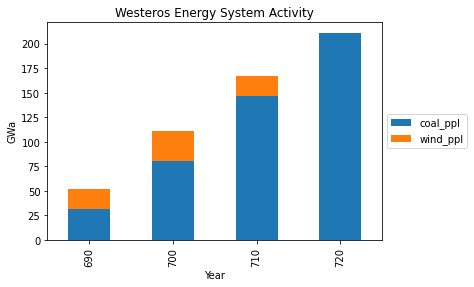

In [36]:
e.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

Plotting the LED VS BULB

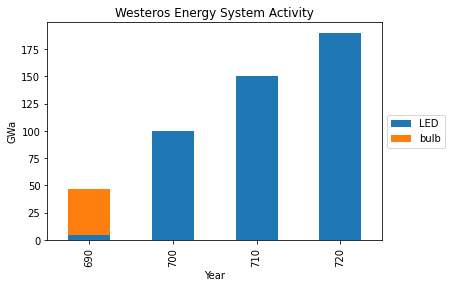

In [37]:
e.plot_activity(baseyear=True, subset=['bulb', 'LED'])

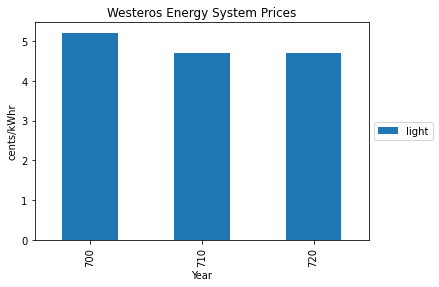

In [38]:
e.plot_prices(subset=['light'], baseyear=True)

Now to have LED take over the world we need to tax CO2 to 23 each decade. If the user tries now to put the tax to 22 per decade it can be noticed that the technology will survive until the 700. After that bulb will take over and win the light war. <br>
It is possible to go back to the taxation box and change the values. There is a commented line to help you out finding which is the value.

## What about the diffusion rate?

Let's now analyse what happens when the diffusion rate of the LED technology is capped manually by the user.

But first we add a new scenario, just for safety. By cloning this from the *emissions* scenario, we are taking in also the same taxation.

In [39]:

diffusion = babe.clone(model, 'diffusion_rate','change diffusion rate to check generation',
                  keep_solution=False)
diffusion.check_out()

RuntimeError: This Scenario is currently locked by user casamassima

In [ ]:
#DIFFUSION RATE
base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

growth_technologies = [
    "LED"
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0.01)    
    diffusion.add_par('growth_activity_up', df)


In [ ]:
diffusion.commit(comment='setting the diffusion rate different now')

In [ ]:
diffusion.solve()

In [ ]:
emissions.var('EMISS', {'node': 'Westeros'})

In [ ]:
e.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

In [ ]:
e.plot_activity(baseyear=True, subset=['bulb', 'LED'])

In [ ]:
e.plot_prices(subset=['light'], baseyear=True)

## Changing diffusion rates 

In [ ]:
mp.close_db()